# **Automating Job-Candidate Matchmaking: Leveraging NLP for Enhanced Recruitment Efficiency**




# 1. Introduction

* **Purpose of the Project:** The objective of this project is to develop an automated system that enhances the recruitment process by efficiently matching job postings with suitable candidate resumes. Utilizing advanced Natural Language Processing (NLP) techniques, the project aims to streamline the identification of potential candidates for job openings, thus reducing the time and resources required for recruitment.

* **Main Assumptions:** 
    * The datasets collected from LinkedIn and livecareer.com are comprehensive and representative of the current job market and candidate pool.
    * NLP and machine learning models can effectively understand, summarize, and extract key information from job descriptions and resumes.
    * The methodology used for matching candidates to job postings based on relevance scores will significantly improve the recruitment process's efficiency and accuracy.



# 2. Data

* **Description of the Data Set:**
    * **LinkedIn Job Posting Dataset:** This dataset, compiled from the LinkedIn Job Posting API, includes over 30,000 job postings, enriched with diverse categories, titles, descriptions, and other categorical metadata.
    * **Resume Dataset:** Sourced from Kaggle and originally collected from livecareer.com, this dataset features 2,400+ resume samples, complete with textual descriptions and various metadata, providing a rich basis for candidate profiling.


* **Preparation of Data for Modeling:**
    * Detailed preprocessing steps were undertaken to cleanse both datasets, involving normalization of text, removal of irrelevant information, and handling of missing data.
    * Data preparation also included feature extraction and the transformation of textual data into a structured format suitable for machine learning models, employing techniques like tokenization and vectorization.



# 3. Modeling

The project explored several NLP models for document summarization, keyword extraction, and matching, including:

* **Doc2Vec:** Used for generating vector embeddings of job postings and resumes, facilitating the calculation of cosine similarity to gauge relevance.
* **BERT:** Employed for its transformer-based capabilities in document embedding and summarization, providing nuanced text interpretation.
* **GPT-3.5:** Leveraged for advanced document summarization and keyword generation, capturing the essential elements of job descriptions and resumes.

Extensive Exploratory Data Analysis (EDA) was conducted to gain insights into the datasets and inform the modeling approach.



# 4. Evaluation

Evaluation of the model's performance included:

* Analysis of relevance scores between job postings and candidate resumes to assess the accuracy and efficiency of the matchmaking process.
* Comparative analysis of our trained model "Doc2Vec" with well-reputed model "GPT-3.5" to evaluate the efficiency. 



# 5. Summary

* **Was the Purpose Achieved?:** The project successfully developed an NLP-based system capable of automating the matchmaking between job postings and resumes, demonstrating a significant improvement in recruitment efficiency.
* **Were the Assumptions Examined?:** The initial assumptions regarding the datasets and the capabilities of NLP models were thoroughly examined and validated through the project's outcomes.
* **Conclusions from Obtained Results:** The project highlighted the potential of NLP in transforming recruitment processes, with the models showing promising results in accurately matching candidates to job openings. Future work, including the potential for resume rewriting, could further enhance the system's effectiveness.












### Import necessary packages

In [1]:
!pip install datasets evaluate rouge_score transformers transformers[torch] bitsandbytes sentence-transformers
!pip install openai --upgrade
!pip install typing_extensions==4.7.1 --upgrade

In [71]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import reduce # module to help merge multiple dataframe
from wordcloud import WordCloud # module to print word cloud
from copy import deepcopy
from difflib import SequenceMatcher
from pathlib import Path
from scipy.stats import norm
import re

# For plotting
import matplotlib.pyplot as plt # for plotting chart
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from sklearn.metrics.pairwise import cosine_similarity

# Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Sentence BERT
from sentence_transformers import SentenceTransformer

# GPT3.5
import openai
from kaggle_secrets import UserSecretsClient

## Job Description Dataset Preparation

In [138]:
job_data = pd.read_csv("/kaggle/input/linkedin-job-postings/job_postings.csv")

chosen_column = ['title', 'description']
job_data = job_data[chosen_column]
job_data = job_data.dropna()

job_data

,title,description
0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...
1,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...
2,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...
3,Cook,descriptionTitle\n\n Looking for a great oppor...
4,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ..."
...,...,...
33241,Sales Manager,Are you a dynamic and creative marketing profe...
33242,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu..."
33243,Franchise Owner,DuctVentz is a dryer and A/C – heat vent clean...
33244,Licensed Insurance Agent,While many industries were hurt by the last fe...


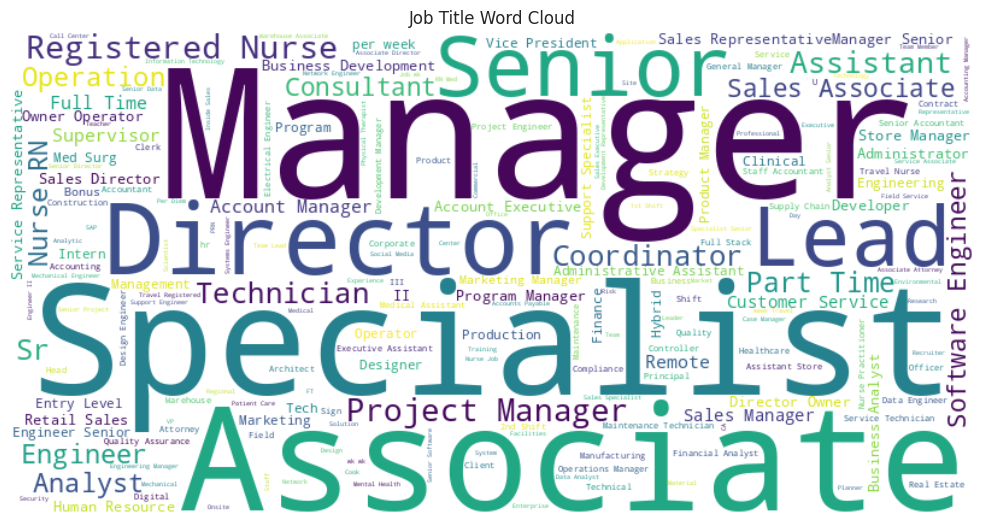

In [139]:
job_titles_text = ' '.join(job_data['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(job_titles_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Job Title Word Cloud')
plt.axis('off')
plt.tight_layout()
plt.show()

## Resume Data Preparation

In [140]:
resume_data = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
choosen_column = ['Resume_str','Category']
resume_data = resume_data[choosen_column]

pretty_column_name = {'Category': 'category', 'Resume_str': 'description'}
resume_data = resume_data.rename(columns=pretty_column_name)
resume_data = resume_data.dropna()
resume_data

,description,category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
2479,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION
2480,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION
2481,GEEK SQUAD AGENT Professional...,AVIATION
2482,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION


### Sampling from all data

This step is needed so we're able to run quickly to iterate our models.

In [173]:
job_data_sample = job_data.sample(n=2_00, random_state=123, ignore_index=True).copy(deep=True)
resume_data_sample = resume_data.sample(n=50, random_state=123, ignore_index=True).copy(deep=True)

## Matching Job Descriptions and Resumes

We would match jobs agains resumes using the following alogorithm with multiple models - 

* Calculate document embeddings vectors of job descriptions and resume descriptions using unsupervised document/text embedding models
*  Calculate a 2D matrix consisting of pairwise cosine similarity score between each pair of job and resume - which would be a number between 0 and 1. The higher the score the better the pair match.

### Doc2Vec Document Embeddings

In [174]:
doc2vec = Doc2Vec(
    vector_size = 50, # Dimensionality of the feature vectors
    min_count = 10, # Ignores all words with a total frequency lower than this
    epochs = 10, # Number of iterations (epochs) over the corpus. Defaults to 10 for Doc2Vec
)

doc2vec_train_set = job_data.sample(n=2_000, random_state=123, ignore_index=True).copy(deep=True)
tagged_data = [TaggedDocument(words = word_tokenize(_d.lower()), tags = [str(i)]) for i, _d in enumerate(doc2vec_train_set['description'])]
doc2vec.build_vocab(tagged_data)

doc2vec.train(
    tagged_data,
    total_examples = doc2vec.corpus_count,
    epochs = doc2vec.epochs
)
doc2vec.save('doc2vec.model')
print("Model saved")

In [184]:
trained_doc2vec = Doc2Vec.load('doc2vec.model')

job_descriptions = job_data_sample['description']
resume_descriptions = resume_data_sample['description']

# Encoding the job descriptions and the resumes to obtain their embeddings
doc2vec_job_embeddings = [trained_doc2vec.infer_vector(description.split()) for description in job_descriptions]
doc2vec_resume_embeddings = [trained_doc2vec.infer_vector(description.split()) for description in resume_descriptions]

# Calculating the cosine similarity between the job embeddings and the resume embeddings
doc2vec_similarity_scores = cosine_similarity(doc2vec_job_embeddings, doc2vec_resume_embeddings)

print(doc2vec_similarity_scores)

[[ 0.2587561   0.18960153  0.36664826 ...  0.21176343  0.30053884
   0.1826317 ]
 [ 0.1182744   0.26966652  0.3904035  ...  0.18999289  0.38323075
   0.14592193]
 [ 0.03892886  0.15595931  0.02753353 ...  0.05468465  0.37100574
   0.23805195]
 ...
 [ 0.04134157  0.00093318 -0.13335751 ...  0.07172959  0.34877822
   0.08979671]
 [ 0.22345431  0.45819905  0.35310602 ...  0.12209946 -0.06480596
   0.26628867]
 [ 0.1626854   0.25082943  0.23190472 ...  0.15564732  0.20392717
   0.14038506]]


### Sentence Transformers (SBERT) Embeddings

In [135]:
job_descriptions = job_data_sample['description']
resume_descriptions = resume_data_sample['description']

# Initializing the Sentence Transformer model using BERT
sbert = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')

# Encoding the job descriptions and the resumes to obtain their embeddings
sbert_job_embeddings = sbert.encode(job_descriptions)
sbert_resume_embeddings = sbert.encode(resume_descriptions)

# Calculating the cosine similarity between the job embeddings and the resume embeddings
sbert_similarity_scores = cosine_similarity(sbert_job_embeddings, sbert_resume_embeddings)

print(sbert_similarity_scores)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

[[0.24766862 0.24051258 0.35699388 ... 0.29817656 0.23786828 0.39058363]
 [0.3160467  0.26723397 0.46966594 ... 0.34740674 0.38246396 0.41259342]
 [0.19027546 0.18794776 0.1707963  ... 0.23339516 0.20894422 0.19918646]
 ...
 [0.201523   0.16601908 0.17638157 ... 0.19286217 0.24827921 0.23427567]
 [0.36382028 0.4412737  0.54149026 ... 0.50716555 0.35734227 0.5516322 ]
 [0.35994    0.3635335  0.38225666 ... 0.44251066 0.39596012 0.39704144]]


### GPT3.5 Text Embeddings

In [136]:
job_descriptions = job_data_sample['description']
resume_descriptions = resume_data_sample['description']

# Initializing Text Embedding extraction using GPT3.5
openai.api_key = UserSecretsClient().get_secret('OPENAI-SECRET')
gpt_engine = "text-embedding-3-large"

def get_gpt_embedding(text):
   text = text.replace("\n", " ")
   return openai.embeddings.create(input = [text], model=gpt_engine).data[0].embedding

# Encoding the job descriptions and the resumes to obtain their embeddings
gpt_job_embeddings = [get_gpt_embedding(description) for description in job_descriptions]
gpt_resume_embeddings = [get_gpt_embedding(description) for description in resume_descriptions]

# Calculating the cosine similarity between the job embeddings and the resume embeddings
gpt_similarity_scores = cosine_similarity(gpt_job_embeddings, gpt_resume_embeddings)

print(gpt_similarity_scores)




[[0.25823654 0.22043456 0.26496154 ... 0.24271514 0.17920464 0.25344653]
 [0.24798457 0.19687966 0.27305982 ... 0.23842961 0.22396243 0.25027881]
 [0.2272493  0.23411489 0.27117076 ... 0.21435034 0.26124279 0.27012964]
 ...
 [0.31642323 0.26323766 0.33124267 ... 0.30247616 0.29631669 0.27566307]
 [0.29446337 0.23859598 0.35261982 ... 0.29590367 0.2155929  0.28328173]
 [0.28532313 0.31122358 0.30007797 ... 0.26519308 0.25445785 0.26336508]]


## Validation

We would use GPT3.5 scores as the ideal score as that uses a large pretrained text embedding model from Open AI. We would compare the cosine similary between the scores provided by our locally trained Doc2Vec model and pretrained SBERT.

## Validation of SBERT Match Scores

SBERT scored pretty similar to gpt3.5 as expected. Overall relative accuracy is **96.7%**.

In [180]:
relative_accuracy = cosine_similarity(sbert_similarity_scores, gpt_similarity_scores)
print("Relative accuracy of SBERT for all pairs: \n", relative_accuracy)
print("\nOverall relative accuracy of SBERT: ", np.mean(relative_accuracy * 100))

Relative accuracy of SBERT for all pairs: 
 [[0.97754353 0.97054924 0.96566503 ... 0.97517287 0.97914819 0.97128633]
 [0.97017939 0.98349328 0.97728998 ... 0.97703125 0.96352581 0.96488871]
 [0.94808038 0.95914309 0.97378833 ... 0.94963237 0.93460512 0.9418781 ]
 ...
 [0.96009356 0.96090019 0.95850179 ... 0.97377836 0.95956878 0.96387537]
 [0.96900764 0.96204048 0.9572658  ... 0.9686265  0.98555863 0.96413204]
 [0.98384756 0.97543188 0.9710509  ... 0.9821267  0.97895628 0.98690981]]

Overall relative accuracy of SBERT:  96.665786807608


## Validation of Doc2Vec Match Scores

Doc2Vec scorer lower compared to gpt3.5. Overall relative accuracy is **87.4%**. The reason behind this is the smaller train set (only 2000 documents).

In [182]:
relative_accuracy = cosine_similarity(doc2vec_similarity_scores, gpt_similarity_scores)
print("Relative accuracy of Doc2Vec for all pairs: \n", relative_accuracy)
print("\nOverall relative accuracy of Doc2Vec: ", np.mean(relative_accuracy * 100))

Relative accuracy of Doc2Vec for all pairs: 
 [[0.95761045 0.9434245  0.95768381 ... 0.95417092 0.93508065 0.94702942]
 [0.86359389 0.88112574 0.86949135 ... 0.88763757 0.87055722 0.87317601]
 [0.81124096 0.81359864 0.84113144 ... 0.81398307 0.79048297 0.80894563]
 ...
 [0.54934908 0.58780989 0.60946287 ... 0.59338142 0.53967611 0.55575561]
 [0.8416646  0.80336378 0.82431327 ... 0.81340542 0.85665445 0.83418603]
 [0.90348524 0.88474537 0.90576875 ... 0.88567437 0.89089022 0.89079222]]

Overall relative accuracy of Doc2Vec:  87.41448535902457
